## edite,release _10 for training and release _11 for test
# same az 14 sep but edited release 10 and 11 

## Pre-processing ##
Now that everything is set up, we want to load our data, but first we need to load a couple of useful python packages:


In [1]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow import keras

# load and plot dataset from segments.ai

In [2]:
from segments import SegmentsClient, SegmentsDataset
from segments.utils import export_dataset
from segments.utils import get_semantic_bitmap

# Initialize a SegmentsDataset from the release file
client = SegmentsClient('90318fc9b60907bf6cb076a9ca21a6b70ae935c5')
dataset_name_11 = 'idakh/line11_new'
dataset_name_8 = 'idakh/line_8'
dataset_name_10 = 'idakh/line10_new'
dataset_name_3 = 'idakh/line3'

# Get a list of image URLs

release_11= client.get_release(dataset_name_11, 'f0.11') # Alternatively: release = 'flowers-v1.0.json'
release_8 = client.get_release(dataset_name_8, 'f0.8') # Alternatively: release = 'flowers-v1.0.json'
release_10 = client.get_release(dataset_name_10, 'f0.10') # Alternatively: release = 'flowers-v1.0.json'
release_3 = client.get_release(dataset_name_3, 'f0.3') # Alternatively: release = 'flowers-v1.0.json'

Initialized successfully.


Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.62it/s]

Initialized dataset with 1 images.


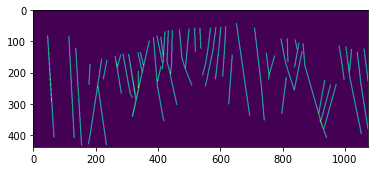

In [3]:
dataset = SegmentsDataset(release_11)
for sample in dataset:
    label = get_semantic_bitmap(sample['segmentation_bitmap'], sample['annotations'])
    
plt.imshow(label)

In [4]:
np.unique(label)

array([0, 2])

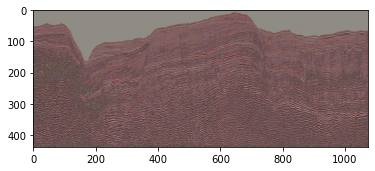

In [5]:
a = sample['image']
plt.imshow(np.array(a))

Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Initialized dataset with 1 images.


Initializing dataset...
Preloading all samples. This may take a while...


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]

Initialized dataset with 1 images.


Initializing dataset...
Preloading all samples. This may take a while...


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.77it/s]

Initialized dataset with 1 images.


Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.74it/s]

Initialized dataset with 1 images.


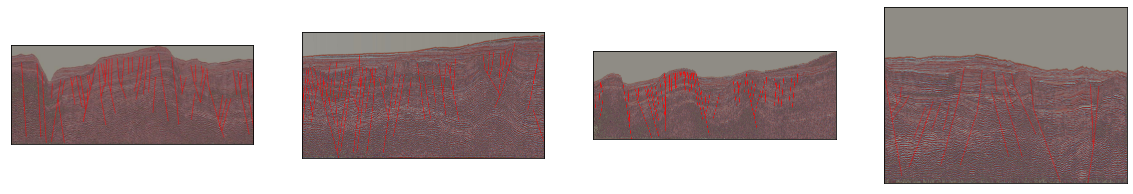

In [6]:
# from google.colab import widgets

def load_data_label(release):
    dataset = SegmentsDataset(release)
    for sample in dataset:
        label = get_semantic_bitmap(sample['segmentation_bitmap'], sample['annotations'])
        data = np.asarray(sample['image']) / 255.
        #converting to grayscale
#         data = 0.2989*data[:,:,0] + 0.5870*data[:,:,1] + 0.1140*data[:,:,2]
#         data = Image.open(data_dir + sample['file_name'])
    label = np.asarray(label)
    return data, label


def plot_overlay(image, label, i):
    (tmax, xmax) = np.shape(label)

    label_rgb = np.zeros((tmax,xmax,4), 'uint8')
    label_rgb[:,:,0] = 255
    label_rgb[:,:,1] = 255 - 255*label
    label_rgb[:,:,2] = 255 - 255*label
    label_rgb[:,:,3] = 255*label   
    
    img = Image.fromarray(label_rgb, mode='RGBA')
    
#     img_gray = 0.2989*image[:,:,0] + 0.5870*image[:,:,1] + 0.1140*image[:,:,2]
    image_rgb = np.zeros((tmax,xmax,3), 'uint8')    
    image_rgb[:,:,0] = 255*image[:,:,0]
    image_rgb[:,:,1] = 255*image[:,:,1]
    image_rgb[:,:,2] = 255*image[:,:,2]
#     image_rgb[:,:,0:3] = 255. * image
#     image_rgb[:,:,3] = 255
    
    background = Image.fromarray(image_rgb, mode='RGB') 
    background.paste(img, (0, 0), img)

#     background = Image.fromarray(image_rgb, mode='RGBA') 
#     print(image.shape)
#     print(label.shape)
#     background.paste(label, (0, 0), label)

    plt.subplot(1,4,i+1).imshow(background)
    plt.xticks([])
    plt.yticks([])



release = [release_11, release_8, release_10, release_3]
plt.figure(figsize=(20,20))
for i, rel in enumerate(release):
    
    data, label = load_data_label(rel)
    plot_overlay(data, label, i)
    plt.xticks([])
    plt.yticks([])

make training and validation dataset, (patchify, size of patch, ...),
## here I chenge window size from 64 to 128,
## I used release_10 for train   and  release_11 for validation
## I changed from gray scale to RGB
##  the patches is square 

In [7]:
def patchify(data, label, size, number, threshold):

    (t_max, x_max) = label.shape    
    X = np.zeros((number, size, size, 3))
    Y = np.zeros((number, size, size, 1))
        
    n = 0
    while n < number: 
        x = random.randint(size//2, x_max-size//2)
        t = random.randint(size//2, t_max-size//2)
        if np.count_nonzero(label[t-size//2:t+size//2, x-size//2:x+size//2]) > threshold:
            X[n,:,:,:]  = data[t-size//2:t+size//2, x-size//2:x+size//2, :]
            Y[n,:,:,0]  = label[t-size//2:t+size//2, x-size//2:x+size//2]
            n = n + 1
    return X, Y


# Parameters
size       = 128
threshold  = 0
num_train  = 10000
num_val    = 2000


# Validation data from inline 300
X_val = np.zeros((num_val,size,size,3))
Y_val = np.zeros((num_val,size,size,1))

seismic, label = load_data_label(release_10)

X_val, Y_val = patchify(seismic, label//2, size, num_val, threshold)


# Training data from inlines 100, 200, 400, 500
X_train = np.zeros((num_train,size,size,3))
Y_train = np.zeros((num_train,size,size,1))

release_list = [ release_11]
n = 0
for release in release_list:
    seismic, label = load_data_label(release)
    
    X_train[n:n+num_train//1,...], Y_train[n:n+num_train//1,...] = patchify(seismic, label//2, size, num_train//1, threshold) 
    n += num_train//1

Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Initialized dataset with 1 images.


Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.66it/s]

Initialized dataset with 1 images.


Before training, it's always a good idea to check the training data, so let's do that:

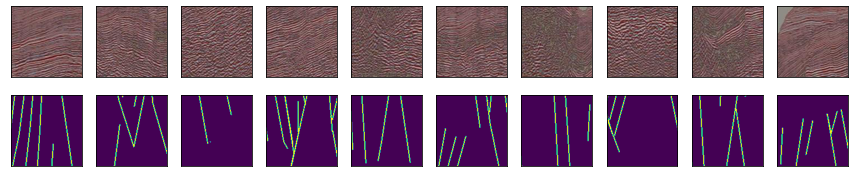

In [17]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))

K = []
for m in range(10):
    k = random.randint(0,4000)
    K.append(k)
    axs[0,m].imshow(X_train[k,:,:,:], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
    axs[0,m].set_xticks([])
    axs[0,m].set_yticks([])

# K = np.stack(K)
for m in range(10):
    axs[1,m].imshow(Y_train[K[m],:,:,0], interpolation='spline16', aspect=1)
    axs[1,m].set_xticks([])
    axs[1,m].set_yticks([])
    k += 1


What do you notice?

* Is it an easy task?
* Could you predict the masks?
* Can we learn more from some examples?

## Training ##
To train our model, we need to define its architecture. 



In [23]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

  


def UNet():
  f = [16, 32, 64, 128, 256]
  inputs = tf.keras.layers.Input((size, size, 3))
  
  p0 = inputs
  c1, p1 = down_block(p0, f[0]) #128 -> 64
  c2, p2 = down_block(p1, f[1]) #64 -> 32
  c3, p3 = down_block(p2, f[2]) #32 -> 16
  c4, p4 = down_block(p3, f[3]) #16->8
  
  bn = bottleneck(p4, f[4])
  
  u1 = up_block(bn, c4, f[3]) #8 -> 16
  u2 = up_block(u1, c3, f[2]) #16 -> 32
  u3 = up_block(u2, c2, f[1]) #32 -> 64
  u4 = up_block(u3, c1, f[0]) #64 -> 128
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
  model = tf.keras.models.Model(inputs, outputs)
  return model



# size = 128
model = UNet()
#model.compile(optimizer="adam", loss="mean_absolute_error", metrics=["acc"])
model.compile(loss='mean_absolute_error', optimizer="adam", metrics=['mse'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 128, 16  2320        ['conv2d_38[0][0]']              
                                )                                                           

### Now you can train your convolutional neural net using the data generator:
##I increased epochs rank!(30 times my model was trained)

In [25]:
from keras.callbacks import CSVLogger
csvlogger = CSVLogger('history_8_oct_mean_absolute_error.csv', append=True)
history = model.fit(X_train, 
                    Y_train, 
                    validation_data=(X_val, Y_val), 
                    epochs=29,
                    callbacks=[csvlogger])

model.save('checkpoint_tot3_8_oct_mean_absolute_error')

Epoch 1/29
313/313 [==============================] - 545s 2s/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0935 - val_mse: 0.0935
Epoch 2/29
313/313 [==============================] - 524s 2s/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0935 - val_mse: 0.0935
Epoch 3/29
313/313 [==============================] - 513s 2s/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0935 - val_mse: 0.0935
Epoch 4/29
313/313 [==============================] - 513s 2s/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0935 - val_mse: 0.0935
Epoch 5/29
313/313 [==============================] - 497s 2s/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0935 - val_mse: 0.0935
Epoch 6/29
313/313 [==============================] - 492s 2s/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0935 - val_mse: 0.0935
Epoch 7/29
313/313 [==============================] - 499s 2s/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0935 - val_mse: 0.0935
Epoch 8/29
313/313 [==============================] - 497s 2s/step - 

INFO:tensorflow:Assets written to: checkpoint_tot3_8_oct_mean_absolute_error\assets


INFO:tensorflow:Assets written to: checkpoint_tot3_8_oct_mean_absolute_error\assets


To visualize our training, you can plot learning curves:

In [29]:
model.load_weights('checkpoint_tot3_8_oct_mean_absolute_error')

In [30]:
import pandas as pd
history = pd.read_csv('history_8_oct_mean_absolute_error.csv')

In [36]:
!pip install matplotlib



In [38]:
import matplotlib.pyplot as plt

In [44]:
##https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
_, train_mse = model.evaluate(X_train, Y_train, verbose=0)
_, test_mse = model.evaluate(X_train, Y_train, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))


Train: 0.042, Test: 0.042


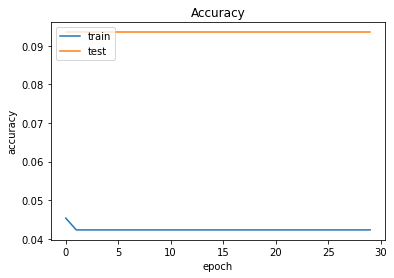

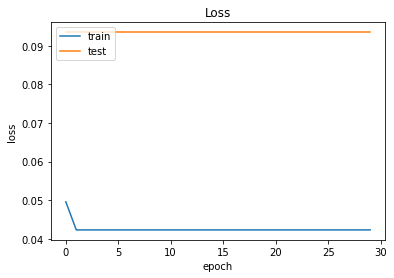

In [46]:
plt.plot(history.mse)
plt.plot(history.val_mse)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.loss)
plt.plot(history.val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

and a confusion matrix:

In [47]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_val)
Y_true = Y_val    

cm = np.zeros((2,2))

for n in range(Y_true.shape[0]):

  y_true = Y_true[n,:,:,0].round().flatten()
  y_pred = Y_pred[n,:,:,0].round().flatten()

  cm_batch = confusion_matrix(y_true, y_pred)
              

  cm = cm + cm_batch

63/63 [==============================] - 17s 273ms/step


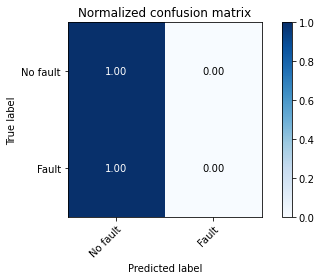

In [48]:
cmap=plt.cm.Blues
normalize = True

title = 'Normalized confusion matrix'


# Only use the labels that appear in the data
classes = ['No fault','Fault']

# Normalize
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


fig, ax = plt.subplots()
im = ax.imshow(cm_norm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm_norm.shape[1]),
       yticks=np.arange(cm_norm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
                ha="center", va='center',
                color="white" if cm_norm[i, j] > thresh else "black")
fig.tight_layout()

# faeiled

##Application##
Now we can apply our model to the entire image to see how well it has learned to recognize salt structures in our seismic image:

In [ ]:
def tile(data, size_h, size_w, dt, dx):
    
    (t_max, x_max, _) = data.shape    
    
    n_patch = (t_max//dt+1)*(x_max//dx+1)
    data_patch = np.zeros((n_patch,size_h,size_w,3)) 

    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):    
            if t_max - t < size_h and x_max - x < size_w:
                data_patch[n,:,:,:] = data[t_max-size_h:t_max, x_max-size_w:x_max]
            elif x_max - x < size_w:
                data_patch[n,:,:,:] = data[t:t+size_h, x_max-size_w:x_max]
            elif t_max - t < size_h:
                data_patch[n,:,:,:] = data[t_max-size_h:t_max, x:x+size_w]
            else:
                data_patch[n,:,:,:] = data[t:t+size_h,x:x+size_w]  
            n = n + 1
    
    return data_patch 




def merge(data_patch, t_max, x_max, size_h, size_w, dt, dx):

    data_new = np.zeros((t_max, x_max,3))
    count = np.zeros((t_max, x_max, 1))
    
    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):
            if t_max - t < size_h and x_max - x < size_w:
                data_new[t_max-size_h:t_max, x_max-size_w:x_max,:] += data_patch[n,:,:,:]
                count[t_max-size_h:t_max, x_max-size_w:x_max,0] += 1
            elif x_max - x < size_w:
                data_new[t:t+size_h, x_max-size_w:x_max,:] += data_patch[n,:,:,:]
                count[t:t+size_h, x_max-size_w:x_max,0] += 1 
            elif t_max - t < size_h:
                data_new[t_max-size_h:t_max, x:x+size_w,:] += data_patch[n,:,::]
                count[t_max-size_h:t_max, x:x+size_w,0] += 1
            else:
                data_new[t:t+size_h,x:x+size_w,:] += data_patch[n,:,:,:]
                count[t:t+size_h,x:x+size_w,:] += 1 
            n = n + 1

    return data_new/count

def plot_overlay(image, label, i):
    (tmax, xmax) = np.shape(label)

    label_rgb = np.zeros((tmax,xmax,4), 'uint8')
    label_rgb[:,:,0] = 255
    label_rgb[:,:,1] = 255 - 255*label
    label_rgb[:,:,2] = 255 - 255*label
    label_rgb[:,:,3] = 255*label   
    
    img = Image.fromarray(label_rgb, mode='RGBA')
    
    image_rgb = np.zeros((tmax,xmax,4), 'uint8')    
    image_rgb[:,:,0] = 255*image[:,:,0]
    image_rgb[:,:,1] = 255*image[:,:,1]
    image_rgb[:,:,2] = 255*image[:,:,2]
#     image_rgb[:,:,0:3] = 255. * image
    image_rgb[:,:,3] = 255
    
    background = Image.fromarray(image_rgb, mode='RGBA') 
    background.paste(img, (0, 0), img)

#     background = Image.fromarray(image_rgb, mode='RGBA') 
#     print(image.shape)
#     print(label.shape)
#     background.paste(label, (0, 0), label)

    plt.subplot(1,5,i+1).imshow(background)
    plt.xticks([])
    plt.yticks([])




In [ ]:
dt = 64
dx = 64

data, label = load_data_label(release_11)
# data = data[:700, :800]
# lable = label[:700, :800]
(t_max, x_max, _) = data.shape

plt.figure(figsize=(80,20))
    
for i in range(1): 
    data_tiles   = tile(data, size, dt, dx)
    result_tiles = model.predict_on_batch(data_tiles)
    result       = merge(result_tiles, t_max, x_max, size, dt, dx)
    plot_overlay(data, result[:,:,0], i)
    plt.xticks([])
    plt.yticks([])

In [ ]:
dt = 128
dx = 128
data, label = load_data_label(release_10)
(t_max, x_max, _) = data.shape

plt.figure(figsize=(80,20))
    
for i in range(1): 
    data_tiles   = tile(data, size_h, size_w, dt, dx)
    result_tiles = model.predict_on_batch(data_tiles)
    result       = merge(result_tiles, t_max, x_max, size_h, size_w, dt, dx)
    plot_overlay(data, result[:,:,0], i)
    plt.xticks([])
    plt.yticks([])

In [ ]:

dt = 128
dx = 128
data, label = load_data_label(release_6)
(t_max, x_max) = data.shape


plt.figure(figsize=(80,20))
    
for i in range(1): 
    data_tiles   = tile(data, size, dt, dx)
    result_tiles = model.predict_on_batch(data_tiles)
    result       = merge(result_tiles, t_max, x_max, size, dt, dx)
    plot_overlay(data, result[:,:,0], i)
    plt.xticks([])
    plt.yticks([])

Not too bad for a first try! Check inline 300, which shows our predictions on a seismic line that it has not seen before. The model is able to find some of the clearer faults (bottom left) in the image. That's promising! Maybe we can even map these faults in a horizontal slice through the volume:

In [ ]:
#depth = 420
#time_slice = data
plt.figure(figsize=(10,10))
plt.imshow(data, cmap= plt.cm.gray)
plt.axis('off')
plt.show()

Now let's predict! Again it will take a moment, since we have to process quite a bit of the volume

In [ ]:
# x is inline and y is depth
(xmax, ymax) = data.shape
nexp=(xmax-2*size)*(ymax-2*size)

batch_size = 1000

coord  = np.zeros((batch_size,2),int)
patch = np.zeros((batch_size,size,size,1))
prediction = np.zeros_like(data)



m=0
n_batch = 0
for x in range(size,xmax-size):
        for y in range(size,ymax-size):
            patch[m,:,:,0] = data[x-size//2:x+size//2, y-size//2:y+size//2]
            coord[m,:] = [x, y]                  
            m+=1        
            
            if m == batch_size:
                prediction[coord[:,0], coord[:,1]] = model.predict_on_batch(patch)[:,size//2,size//2,0]
                m=0
                
                print(str(n_batch+1) + ' of ' + str(round(nexp/batch_size)))
                n_batch += 1

In [ ]:
plt.figure(figsize=(80,10))
plot_overlay(data, prediction, 1)